In [53]:
import pandas as pd
import numpy as np
import os, os.path

In [54]:
features = ["Tm", "Rec_ID", "AvgTamb", "AvgHamb", "AvgGSi00", "AvgTSi00", 
            "AvgSPN1_G", "AvgSPN1_D", "AvgWind_S", "AvgWind_D", "AvgAir_P"]
dataf = pd.DataFrame([], columns = features)

In [55]:
def is_non_zero_file(fpath):  
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

In [56]:
# get all txt files from the directory init_dir and all sub-directories
init_dir = "401"
flist  = []
 
for root, dirs, files in os.walk(init_dir):
    try:
        for f in files:
            fullpath = os.path.join(root, f)
            if (is_non_zero_file(fullpath)) & (os.path.splitext(fullpath)[1] == '.txt'):
                flist.append(fullpath)
    except Exception as e:
        raise e
        print( "No files found here!")
# print(flist[1])
print(len(flist))



1122


In [57]:
# generate all the 15-min averages for all the files 
features_to_analyze = ["AvgTSi00", "AvgSPN1_D"]

dataAvg = []

avg_len = 15 # average for every 15 minutes
seq_len = 72 # 72 = 18 hours * 4 (four is the number of 15 min intervals in 1 hour) 

for fullpath in flist:
    # arrays for the 15 min means
    data = pd.read_csv(fullpath,delimiter="\t")        
    pd_len = data.shape[0]  # all length of the sequence
    #     print(fullpath)
    # and then average everything using 15 min reading
    for i in range(0,pd_len-avg_len,avg_len):
        seq_in = data.iloc[i:i + avg_len][features_to_analyze].mean()  # not inclusive the higher limit
        seq_in = np.array(seq_in).reshape(2)
        dataAvg.append(seq_in)
    # and now for list of avg values make a test data    
print("Total sequences: {}".format(len(dataAvg)))

Total sequences: 106572


In [58]:
features_to_analyze = ["AvgTSi00", "AvgSPN1_D"]
featurs_len = len(features_to_analyze)
# print(dataAvg[1][1])

In [59]:
dataX = []
dataY = []

for element in range(0, len(dataAvg)-seq_len-1, 1):
    # and now make a list of test data from avg values
    Z = np.array(dataAvg[element:element+seq_len]).reshape(seq_len,featurs_len)
    dataX.append(Z)
    dataY.append(dataAvg[element+seq_len+1][1])
    
print("Total sequences: {}".format(len(dataX)))

Total sequences: 106499


In [60]:
n_patterns = len(dataX)
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)

(106499, 72, 2)


Normalize all the sequence, 

In [61]:
Mx = X.max(axis=1).max(axis=0)
Mn = X.min(axis=1).min(axis=0)
M = X.mean(axis=1).mean(axis=0)
MM = Mx-Mn

In [62]:
for i in (range(X.shape[0])):
    for j in (range(X.shape[1])):
        X[i][j] -= M
        X[i][j] /= MM

In [63]:
# reshape X to be [samples, time steps, features]
Y = np.reshape(dataY, (n_patterns, 1))
print(Y.shape)


(106499, 1)


In [64]:
Y -= M[1]         
Y /= MM[1]    

In [65]:
np.savez_compressed('data', dataX=dataX, dataY=dataY, X=X, Y=Y)


In [66]:
DataSet = np.load('data.npz')

In [67]:
dataX = DataSet['dataX']
dataY = DataSet['dataY']
n_patterns = len(dataX)

In [68]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)       


(106499, 72, 2)


In [69]:
Mx = X.max(axis=1).max(axis=0)
Mn = X.min(axis=1).min(axis=0)
# print(Z)
# print(len(Z))
# print(Z.shape)

M = X.mean(axis=1).mean(axis=0)
print(M)
MM = Mx-Mn

W = X[3][4]
print(W,"\n",M,"\n",W-M,"\n",MM,"\n",(W-M)/MM)
print((W[1]-M[1])/MM[1])

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)

[  31.89318985  108.12619017]
[ 26.7588       3.08073333] 
 [  31.89318985  108.12619017] 
 [  -5.13438985 -105.04545684] 
 [  50.41953333  664.57513333] 
 [-0.10183335 -0.15806408]
-0.158064079691
(106499, 72, 2)


In [70]:
# reshape X to be [samples, time steps, features]
Y = np.reshape(dataY, (n_patterns, 1))
print(Y.shape)


(106499, 1)


In [71]:
for i in (range(X.shape[0])):
    for j in (range(X.shape[1])):
        X[i][j] -= M 
        X[i][j] /= MM
        
Y -= M[1]         
Y /= MM[1]         

In [72]:
import numpy as np
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf

In [73]:
# define the input shape
print(X.shape)
inp = Input(shape=(X.shape[1], X.shape[2]))
print('our input shape is ',(X.shape[1], X.shape[2]) )

(106499, 72, 2)
our input shape is  (72, 2)


In [74]:
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [75]:
x = LSTM(256, return_sequences = True)(inp) 
x = Dropout(0.2)(x)
x = LSTM(256)(x)
x = Dropout(0.2)(x)
# output = Dense(Y.shape[1])(x)
# model.add(Activation('relu')) #'linear'
# output = Dense(Y.shape[1], activation='relu')(x)
output = Dense(Y.shape[1])(x)

In [76]:
generative_model = Model(inputs = inp, outputs=output)
optimizer = RMSprop(lr=0.01)
generative_model.compile(loss='mean_squared_error', optimizer='RMSprop')


In [77]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gentext-Telemetry.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [78]:
history = generative_model.fit(X, Y, epochs=10, batch_size=64, callbacks=callbacks_list, validation_split=0.2)


Train on 85199 samples, validate on 21300 samples
Epoch 1/10
85199/85199 [==============================] - 1034s - loss: 0.0059 - val_loss: 0.0047
Epoch 2/10
85199/85199 [==============================] - 1003s - loss: 0.0047 - val_loss: 0.0052
Epoch 3/10
85199/85199 [==============================] - 1001s - loss: 0.0046 - val_loss: 0.0051
Epoch 4/10
85199/85199 [==============================] - 1000s - loss: 0.0046 - val_loss: 0.0045
Epoch 5/10
85199/85199 [==============================] - 1004s - loss: 0.0044 - val_loss: 0.0044
Epoch 6/10
85199/85199 [==============================] - 1004s - loss: 0.0044 - val_loss: 0.0047
Epoch 7/10
85199/85199 [==============================] - 1005s - loss: 0.0044 - val_loss: 0.0059
Epoch 8/10
85199/85199 [==============================] - 1003s - loss: 0.0044 - val_loss: 0.0047
Epoch 9/10
85199/85199 [==============================] - 1003s - loss: 0.0046 - val_loss: 0.0047
Epoch 10/10
85199/85199 [==============================] - 1016s - l

In [79]:
# model.save('my_model.h5')
# del generative_model

In [80]:
# from keras.models import load_model
# generative_model = load_model('weights-improvement-06-0.0178-gentext-Telemetry.hdf5')

In [81]:
i=1
x = np.reshape(X[i], (1, X.shape[1], X.shape[2]))
prediction = generative_model.predict(x, verbose=0)

In [82]:
print(prediction)
print(Y[1])
print(abs(Y[1]-prediction)*MM[1])

[[-0.13357939]]
[-0.13861235]
[[ 3.34478374]]


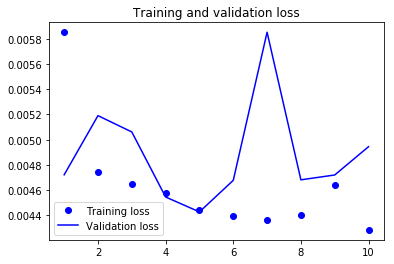

In [83]:
import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [84]:
# Evaluate model with test data set and share sample prediction results
x_test, y_test = X,Y
batch_size = 128
evaluation = generative_model.evaluate(x_test, y_test,
          batch_size=batch_size)


106496/106499 [============================>.] - ETA: 0s

In [85]:
print('Model Loss = %.2f' % (evaluation))
generative_model.save('Tele1_model')

Model Loss = 0.00


In [86]:
preds = generative_model.predict(x_test)

In [87]:
print(type(preds))
len(preds)

<class 'numpy.ndarray'>


106499

In [88]:

Diff = (preds-Y)
type(Diff)
print(Diff[1])
print(np.mean(Diff), np.max(Diff),np.std(Diff))

[ 0.00503295]
0.0148812422881 0.67447753793 0.0682516893246


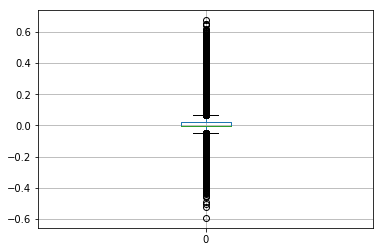

In [89]:
from pandas import DataFrame
results = DataFrame(Diff)
results.boxplot()
plt.show()


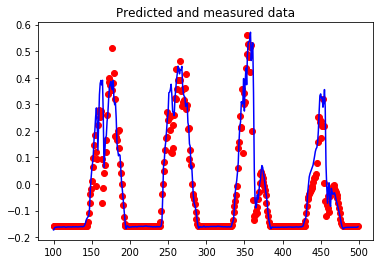

In [90]:
import matplotlib.pyplot as plt
frm = 100
to = 500
intervals15min = range(frm, to)
plt.title('Predicted and measured data')
plt.legend()
plt.plot(intervals15min, Y[intervals15min], 'ro', label='Y_original')
plt.plot(intervals15min, preds[intervals15min], 'b', label='Y_predicted')
plt.show()